## Programming Exercise 2: Logistic Regression

### Setup

In [2]:
# Setup Code
import numpy as np
import matplotlib.pyplot as plt
# For that Surface plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# For the minimization function
from scipy.optimize import minimize
# For generating the polynomial
from sklearn.preprocessing import PolynomialFeatures
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')
# Loading the data
data1 = np.loadtxt('ex2data1.txt',delimiter=',')
data2 = np.loadtxt('ex2data2.txt',delimiter=',')

x1 = data1[:,[0,1]]
y1 = data1[:,2]
x2 = data2[:,[0,1]]
y2 = data2[:,2]

m1 = len(y1)
m2 = len(y2)

### Initial Plot of the data

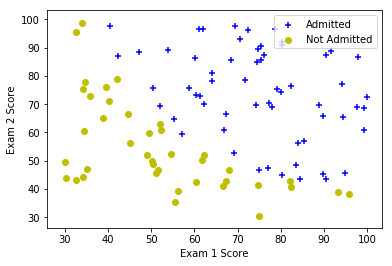

In [3]:
def plot_data(x, y, label_x, label_y, label_pos, label_neg):
    pos = np.where(y == 1)
    neg = np.where(y == 0)

    plt.scatter(x[pos,0],x[pos,1], color='b', marker='+', label=label_pos) #'Admitted')
    plt.scatter(x[neg,0],x[neg,1], color='y', marker='o', label=label_neg) #'Not Admitted')
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    plt.legend(loc='upper right')
    

plot_data(x1, y1, 'Exam 1 Score', 'Exam 2 Score', 'Admitted', 'Not Admitted')
plt.show()

### Implementation

In [4]:
# the sigmoid function
def sigmoid(z):
    g = 1. / (1. + np.exp(-z))
    return g

# the logistic regression cost function + gradient
def cost_function(theta, x, y):
    m = y.size
    h = sigmoid(x.dot(theta))
    J = -1. / m * (np.dot(y, np.log(h)) + np.dot((1-y),np.log(1 - h)))

    return J

def gradient(theta, x, y):
    m = y.size
    h = sigmoid(x.dot(theta))
    grad = 1. / m * x.T.dot(h - y) 
    
    return grad

# Adding the intercept term to X1
r, c = x1.shape
x11 = np.ones((r, c+1))
x11[:, [1,2]] = x1

initial_theta = [0, 0, 0]
J = cost_function(initial_theta, x11, y1)
grad = gradient(initial_theta, x11, y1)

print 'Cost at initial theta: %f' % (J)
print 'Gradients at initial theta:'
print grad

test_theta = [-24, 0.2, 0.2]
J = cost_function(test_theta, x11, y1)
grad = gradient(test_theta, x11, y1)
print '\n'
print 'Cost at test theta: %f' % (J)
print 'Gradients at test theta:'
print grad

Cost at initial theta: 0.693147
Gradients at initial theta:
[ -0.1        -12.00921659 -11.26284221]


Cost at test theta: 0.218330
Gradients at test theta:
[ 0.04290299  2.56623412  2.64679737]


### Learning parameters

Using scipy's minimize function

In [5]:
opt = minimize(cost_function, initial_theta, args=(x11,y1), method=None, jac=gradient, options = {'maxiter':400})

theta_opt = opt.x
print "Cost at test initial theta found with scipy.optimize: %f" % opt.fun
print "Calculated Gradients" 
print theta_opt
## Obviously not suppresing errors. I am at a loss here

Cost at test initial theta found with scipy.optimize: 0.203498
Calculated Gradients
[-25.16133284   0.2062317    0.2014716 ]


### Decision boundary

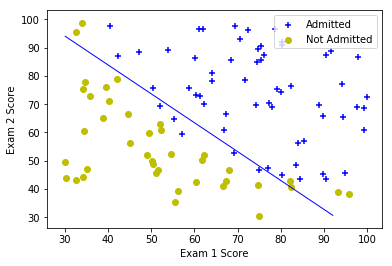

In [6]:
plot_data(x1, y1, 'Exam 1 Score', 'Exam 2 Score', 'Admitted', 'Not Admitted')

x1_min, x1_max = x11[:,1].min(), x11[:,1].max(),
x2_min, x2_max = x11[:,2].min(), x11[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(opt.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
plt.show()


### Predict

In [7]:
prob = sigmoid(np.dot([1, 45, 85], theta_opt))
print 'For a student with scores 45 and 85, we predict an admission: %f'% (prob)

For a student with scores 45 and 85, we predict an admission: 0.776291


In [8]:
def predict(theta, x):
    pr_prob = sigmoid(x.dot(theta.T))
    pr_prob = pr_prob >= 0.5
    return pr_prob.astype(np.int)


p = predict(theta_opt, x11)

print 'Training accuracy: %d percent' % ((p == y1).astype(np.int).mean()*100)

Training accuracy: 89 percent


### Regularized logistic regression

#### Visualizing the data

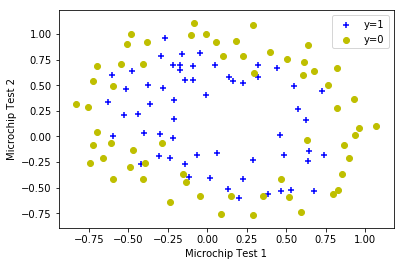

In [9]:
plot_data(x2, y2, 'Microchip Test 1', 'Microchip Test 2', 'y=1', 'y=0')
plt.show()

#### Regularized Cost Function

In [58]:
# Setup
y2 = y2.reshape(y2.size, 1)

# Functions
def cost_fun_reg(theta, x, y, lamb):
    m = y.size
    h = sigmoid(x.dot(theta))
    J = -1. / m * (np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) + float(lamb) / (2 * m) * np.sum(np.square(theta[1:]))
    
    return J

def grad_reg(theta, x, y, lamb):
    m = y.size
    h = sigmoid(x.dot(theta.reshape(-1,1)))
    reg_grad = float(lamb) / m * np.r_[[[1]], theta[1:].reshape(-1,1)]
    grad = 1. / m * x.T.dot(h - y) + reg_grad
    
    return (grad.flatten())

## Feature mapping
poly = PolynomialFeatures(6)
xmp = poly.fit_transform(x2[:,0:2])

initial_theta = np.zeros((xmp.shape[1],1))
_lambda = 1
cost = cost_fun_reg(initial_theta, xmp, y2, _lambda)
grd = grad_reg(initial_theta, xmp, y2, _lambda)

print 'Cost at initial theta: %f' % (cost)
print 'Gradients at initial theta:'
print np.round(grd[0:5], decimals=4)
print '\n'
test_theta = np.ones((xmp.shape[1],1))
cost_t = cost_fun_reg(test_theta, xmp, y2, _lambda)
grd_t = grad_reg(test_theta, xmp, y2, _lambda)

print 'Cost at initial theta: %f' % (cost_t)
print 'Gradients at initial theta:'
print np.round(grd_t[0:5], decimals=4)

Cost at initial theta: 0.693147
Gradients at initial theta:
[ 0.0169  0.0188  0.0001  0.0503  0.0115]


Cost at initial theta: 2.134848
Gradients at initial theta:
[ 0.3545  0.0851  0.1185  0.1506  0.0159]


#### Learning parameters

In [59]:
opt_reg = minimize(cost_fun_reg, initial_theta, args=(xmp,y2,100), method=None, options = {'maxiter':3000})

theta_optr = opt_reg.x
print "Cost at test initial theta found with scipy.optimize: %f" % opt_reg.fun
print "Calculated Gradients" 
print theta_optr

Cost at test initial theta found with scipy.optimize: 0.686484
Calculated Gradients
[ 0.02188606 -0.01748171  0.0057103  -0.05516942 -0.01314889 -0.03859921
 -0.01846357 -0.00773238 -0.00892436 -0.02280492 -0.04343876 -0.00235625
 -0.01415632 -0.00349511 -0.04143635 -0.02100598 -0.00471925 -0.00359134
 -0.00632237 -0.00502444 -0.03197708 -0.03416354 -0.00107629 -0.00702625
 -0.00038508 -0.00798242 -0.00154779 -0.04108712]


#### Prediction

In [60]:
p = predict(theta_optr, xmp)
print 'Training accuracy: %f percent' % ((p == y2.ravel()).astype(np.int).mean()*100)

Training accuracy: 61.016949 percent


### Plotting the Decision Boundary

#### 1. With lambda = 0

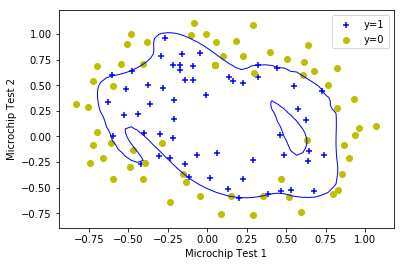

In [61]:
plot_data(x2, y2, 'Microchip Test 1', 'Microchip Test 2', 'y=1', 'y=0')

opt_reg_z = minimize(cost_fun_reg, initial_theta, args=(xmp,y2,0), method=None, jac=grad_reg, options = {'maxiter':3000})

x1_min, x1_max = xmp[:,1].min(), xmp[:,1].max(),
x2_min, x2_max = xmp[:,2].min(), xmp[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(opt_reg_z.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
plt.show()

**Summary:** It can be seen from the figure above that with lambda = 0 it overfits the data

#### 2. With lambda = 1

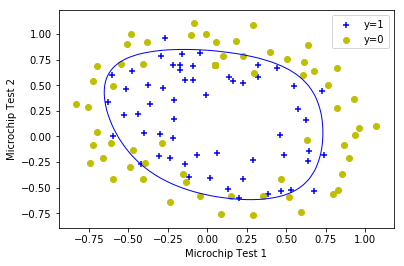

In [62]:
plot_data(x2, y2, 'Microchip Test 1', 'Microchip Test 2', 'y=1', 'y=0')

opt_reg_z = minimize(cost_fun_reg, initial_theta, args=(xmp,y2,1), method=None, jac=grad_reg, options = {'maxiter':3000})

x1_min, x1_max = xmp[:,1].min(), xmp[:,1].max(),
x2_min, x2_max = xmp[:,2].min(), xmp[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(opt_reg_z.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
plt.show()

**Summary:** The figure above shows that the decision boundary is correct

#### 3. With lambda = 100

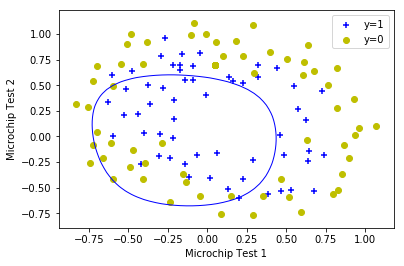

In [63]:
plot_data(x2, y2, 'Microchip Test 1', 'Microchip Test 2', 'y=1', 'y=0')

opt_reg_z = minimize(cost_fun_reg, initial_theta, args=(xmp,y2,100), method=None, options = {'maxiter':3000})

x1_min, x1_max = xmp[:,1].min(), xmp[:,1].max(),
x2_min, x2_max = xmp[:,2].min(), xmp[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(opt_reg_z.x))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
plt.show()

**Summary:** The figure above shows the decision boundary and how it is underfitting. 